# Parsing individual histological cell image data from BreastIHC API

Image and API responses are extracted from MindPeak's [BreastIHC](https://ihc.mindpeak.ai/) app (free registration required)

In [73]:
import pandas as pd
import json
from matplotlib import pyplot as plt
from matplotlib import figure
from matplotlib import gridspec
import numpy as np
import PIL
import math
import os

from skimage import io
from sklearn.model_selection import train_test_split

import tensorflow as tf
import h5py


from Models.Augment import Augment

%matplotlib inline

THIS_DIR = os.path.abspath('')

Responses and associated image from the Ki67 demo images - we can gather more data using uploaded breast cell image data (e.g. from [CAMELYON](http://gigadb.org/dataset/100439))

In [50]:
RESPONSES = [
    "labC_1.bd7b589b",
    "labB_1.fbc70936",
    "labB_0.0456cf3f",
    "labA_0.722f7db3"
]

RESPONSES_DIR = "Responses/"
IMAGES_DIR = "Images/"
DATASETS_DIR = "Datasets/"

CROP_WIDTH = 64

Parses the API response json and adds the associated image data 'thumbnails', both as np.array and a PIL, for each classified cell

In [3]:
def parse_api_response(responses, index, crop_size):
    response_path = RESPONSES_DIR + "response_" + responses[index] + ".json"
    with open(response_path, "r") as f:
        data = json.load(f)
        cell_dict = data["response"]["results"]["cells"]
        df = pd.DataFrame.from_dict(cell_dict)
        
    image_path = IMAGES_DIR + responses[index] + ".png"
    img = plt.imread(image_path)
    
    add_cell_images_to_df(df, img,  crop_size)
    return df

def add_cell_images_to_df(df, img, crop_size):
    image_data = []
    for index, row in df.iterrows():
        center = (df.x[index] + 64, df.y[index] + 64) # center of the region
        crop_offset = math.floor(crop_size/2)
        cropped = img[(center[1] - crop_offset):(center[1] + crop_offset),
                   (center[0] - crop_offset):(center[0] + crop_offset),:]

        image_data.append(cropped)
            
    df["image_data"] = image_data

Reclassifies cell type based on 'intensity' data, I guess that this should be equivalent to moving the Positivity Threshold slider in the BreastIHC GUI, but the numbers don't seem to match up perfectly. Either there is some logic that I'm missing, or it's a bug!

In [4]:
def reclassify_by_intensity(df, intensity_threshold):
    df.loc[df.intensity < intensity_threshold, "type"] = "non_tumor"
    df.loc[df.intensity >= intensity_threshold, "type"] = "tumor"

Reproduces the BreastIHC GUI for a given api response. There is a 64 pixel margin around the FOV where there is no classification, assumedly to mitigate CNN border effects

In [5]:
def display_api_response(responses, index, intensity_threshold):

    df = parse_api_response(RESPONSES, 0, 64)
    reclassify_by_intensity(df, intensity_threshold)

    grouped_by_type = df.groupby("type")
    tumor_cells = grouped_by_type.get_group("tumor")
    non_tumor_cells = grouped_by_type.get_group("non_tumor")
    
    image_path = IMAGES_DIR + responses[index] + ".png"
    img = plt.imread(image_path)
    
    plt.imshow(img)
    point_size = 10
    plt.scatter(tumor_cells.x + 64, tumor_cells.y + 64, s = point_size, c = 'red')
    plt.scatter(non_tumor_cells.x + 64, non_tumor_cells.y + 64, s = point_size, c = 'green')

    fig = plt.gcf()
    fig.set_size_inches(18, 10, forward=True)
    plt.show()
    print("tumor cells: " + str(len(tumor_cells.index))+ "\nnon-tumor cells: " + str(len(non_tumor_cells.index))) 

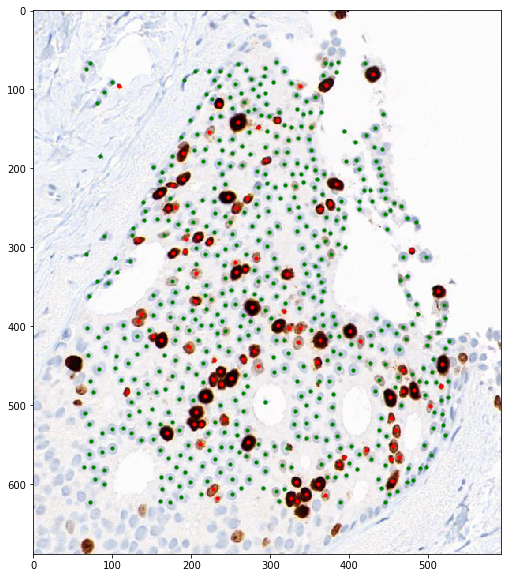

tumor cells: 93
non-tumor cells: 513


In [6]:
display_api_response(RESPONSES, index = 0, intensity_threshold = 0.5)

Display a number of random cell images from the parsed dataframe, along with its classification for some intensity threshold (to check that it's working!)

In [7]:
def show_example_cell_images(df, number_of_images_to_display, intensity_threshold):
    reclassify_by_intensity(cell_df, intensity_threshold)
    
    images_per_row = 5
    
    num_columns = min(number_of_images_to_display, images_per_row)
    num_rows = math.ceil((number_of_images_to_display+1) / images_per_row)
    
    fig = plt.figure()
    fig.set_size_inches(5 * num_columns, 5 * num_rows, forward = True)
    
    gs = gridspec.GridSpec(num_rows, num_columns)
    for i in range(num_columns * num_rows):
        row = (int)(i / num_columns)
        column = i % num_columns
        
        if i < number_of_images_to_display:
            random_cell_index = np.random.randint(0, len(cell_df.index))
            ax = fig.add_subplot(gs[row, column])
            ax.imshow(cell_df["image_data"][random_cell_index], aspect = 'equal')
            cell_type = cell_df["type"][random_cell_index]
            x = cell_df["x"][random_cell_index]
            y = cell_df["y"][random_cell_index]
        
            ax.text(0.5,-0.25, "%s\n(%d, %d)" % (cell_type, x, y), size=20, ha="center", transform=ax.transAxes) 
    
    fig.tight_layout(h_pad=5)
    plt.show()

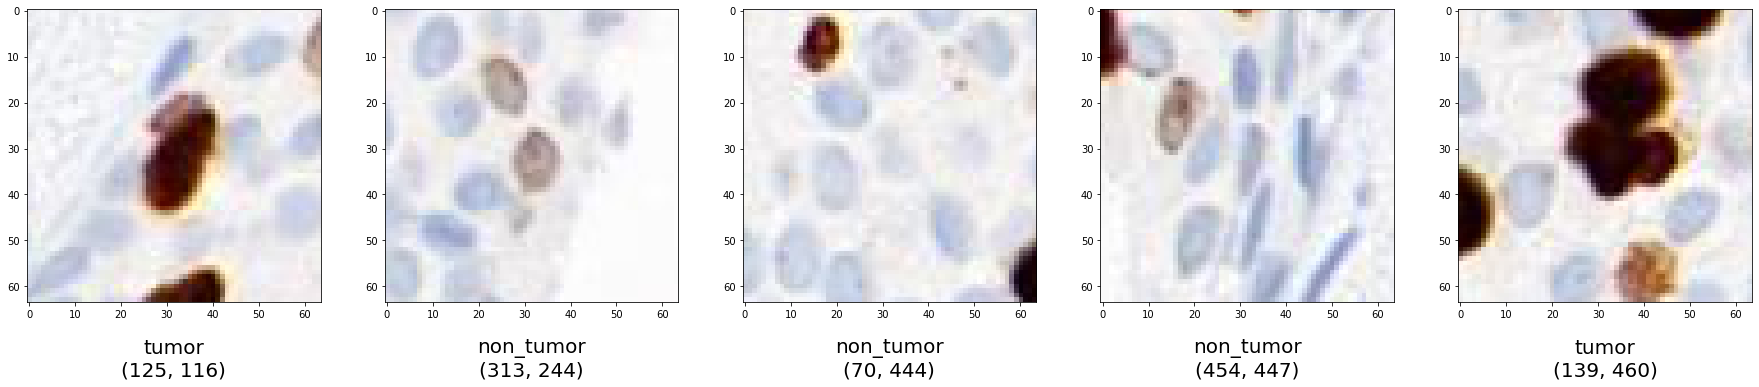

In [8]:
cell_df = parse_api_response(RESPONSES, index = 0, crop_size = 64)
show_example_cell_images(cell_df, number_of_images_to_display = 5, intensity_threshold = 0.5)

Export cell image data with labels for all api responses into a new directory

In [ ]:
def create_cell_image_dataset(responses, crop_size, intensity_threshold, augment = False, transformations = ['rotate', 'flip']):

    data = []
    dataset_name = f"cells_{crop_size}x{crop_size}_it_{int(intensity_threshold * 100)}{'_augmented' if augment else ''}"

    for index, response in enumerate(responses):
        df = parse_api_response(responses, index, crop_size)  
        reclassify_by_intensity(df, intensity_threshold)
        
        print(f"Parsing {response}: {df.shape}")
        
        for index, row in df.iterrows():
            image_data = []
            image_data.append(row["image_data"])
            xCoord = row["x"]
            yCoord = row["y"]

            if augment == True:
                transformed_images = Augment().TransformImage(image_data[0], transformations)
                for transformed_image in transformed_images:
                    image_data.append(transformed_image)
            
            for i in range(0, len(image_data)):
                image_name = f"{response}_{xCoord}_{yCoord}_{i}"
                data.append([image_name, image_data, row["intensity"], row["type"]])
    
    
    dataset_df = pd.DataFrame(data, columns = ['name', 'features', 'intensity', 'target'])
    print(f"Writing dataframe with {len(dataset.index)} rows to {dataset_name}.csv")
    
    return dataset_name, dataset_df

dataset_name, dataset = create_cell_image_dataset_df(RESPONSES, crop_size = 64, intensity_threshold = 0.5, augment = True)

print(f"{dataset_name} -- {dataset.shape}")

In [80]:
def write_dataset_to_csv(dataset, dataset_name):
    this_dir = os.path.abspath('')
    target_dir = os.path.join(this_dir, DATASETS_DIR)
    
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
        
    filepath = os.path.join(target_dir, f"{dataset_name}.csv")
    print(f"Writing {dataset_name} to {filepath}")
    dataset.to_csv(filepath)
    print("\nDone")
    return filepath

write_dataset_to_csv(dataset, dataset_name)

Writing cells_64x64_it_50_augmented to /Users/theoevans/DAI/HistoVAE/Datasets/cells_64x64_it_50_augmented.csv


'/Users/theoevans/DAI/HistoVAE/Datasets/cells_64x64_it_50_augmented.csv'